# Useful link
- https://www.kdnuggets.com/2023/06/advanced-feature-selection-techniques-machine-learning-models.html
- https://www.stratascratch.com/blog/feature-selection-techniques-in-machine-learning/

In [1]:
import os, sys

sys.path.append('/home/ubuntu/crypto_prediction/git/crypto_prediction_ml_dl/script')

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
from trino_operations import trino_operator
import matplotlib.pyplot as plt

from sklearn.decomposition import (PCA, IncrementalPCA,
                                   KernelPCA, TruncatedSVD,
                                   FastICA, MiniBatchDictionaryLearning,
                                   SparsePCA)
from sklearn.manifold import (Isomap,
                              LocallyLinearEmbedding)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import (GaussianRandomProjection,
                                       SparseRandomProjection)
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()

In [2]:
def create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
):
    """Load data form Hive mart table

        Args:
            target_schema: hive schema name
            target_table: hive table name
            target_columns: column name list to load
            target_symbol: symbol name (e.g., BTC_USDT)
            column_prefix: prefix name for each column

        Returns:
            data frame
    """
    query = f"""
    select
        {target_columns}
    from 
        hive.{target_schema}.{target_table}
    where
        id = '{target_symbol}'
    order by dt
    """

    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    target_columns_list = [
        column_prefix + column.strip() for column in target_columns.strip().split(",")
    ]

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=target_columns_list
    )

    return indicators_raw_df

In [29]:
########################
# Load BTC_USDT OHLC and indicators
########################
target_schema = "crypto_mart"
target_table = "crypto_indicator_day"
target_symbol = "BTC_USDT"
column_prefix = "btc_"
target_columns = """
    dt,
    low,
    high,
    open,
    close,
    volume,
    macd,
    macd_single,
    rsi,
    bollinger_bands_sma,
    bollinger_bands_lower_band,
    bollinger_bands_upper_band,
    obv,
    ichimoku_chikou_span,
    ichimoku_kijun_sen,
    ichimoku_tenkan_sen,
    ichimoku_senkou_span_a,
    ichimoku_senkou_span_b,
    stoch_oscillator,
    stoch_signal,
    stoch_percent_j,
    aroon_up,
    aroon_down,
    aroon_oscillator,
    sma5,
    sma10,
    sma30,
    ema5,
    ema10,
    ema30
    """

btc_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)

btc_raw_df.tail()

,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,btc_bollinger_bands_sma,...,btc_stoch_percent_j,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30
1074,2023-10-10,27300.01,27725.80,27590.00,27391.12,28203902.00,302.02830,266.32162,53.238785,27129.957,...,49.545116,68.0,40.0,28.0,27755.621,27685.557,26902.334,27611.684,27531.750,27137.102
1075,2023-10-11,26547.40,27473.75,27394.06,26881.59,23001124.00,232.20303,259.49792,46.473713,27145.348,...,18.351896,64.0,36.0,28.0,27545.771,27577.396,26959.387,27368.320,27413.540,27120.617
1076,2023-10-12,26563.15,26935.01,26878.10,26759.45,19693696.00,165.10706,240.61974,44.997630,27154.418,...,-4.190807,60.0,32.0,28.0,27306.870,27503.473,26990.470,27165.363,27294.613,27097.314
1077,2023-10-13,26685.48,27189.49,26753.69,26862.98,17459042.00,118.91631,216.27905,46.547400,27169.207,...,-10.631476,56.0,28.0,28.0,27095.418,27447.113,27012.053,27064.568,27216.135,27082.197
1078,2023-10-14,26853.74,26890.70,26862.78,26889.28,604814.94,83.46973,189.71720,46.956257,27201.348,...,3.064169,52.0,24.0,28.0,26956.883,27357.814,27024.455,27006.139,27156.707,27069.750


In [30]:
# show the distirbution of data in each of these columns.
btc_raw_df.describe()

,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,btc_bollinger_bands_sma,btc_bollinger_bands_lower_band,...,btc_stoch_percent_j,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30
count,1078.000000,1078.000000,1078.000000,1078.000000,1.078000e+03,1053.000000,1044.000000,1064.000000,1059.000000,1059.000000,...,1061.000000,936.000000,903.000000,1038.000000,1074.000000,1069.000000,1049.000000,1074.000000,1069.000000,1049.000000
mean,32762.245909,34549.964592,33702.887365,33715.711633,2.798141e+07,75.795941,70.317467,51.020720,33940.794142,30028.763400,...,51.337120,58.841880,52.540421,7.352601,33765.607249,33824.968485,34054.392393,33764.532952,33823.156758,34048.568275
std,12601.735209,13462.160696,13079.803129,13067.456834,3.603530e+07,1594.582824,1521.753206,13.579689,12819.503473,11339.007131,...,34.048496,32.108516,31.591494,59.494341,13008.756866,12946.028721,12697.737276,12982.832331,12889.759201,12500.257971
min,13207.510000,13825.000000,13556.050000,13558.840000,1.945060e+03,-5075.484400,-4436.556600,17.769420,15821.848000,13072.249000,...,-30.933695,4.000000,4.000000,-100.000000,14208.216000,14752.828000,16656.650000,14208.216000,14752.828000,16656.650000
25%,22444.410000,23344.697500,22939.605000,22940.520000,4.775556e+06,-802.494260,-735.642285,41.212484,22967.743000,19850.504000,...,22.548950,28.000000,24.000000,-48.000000,22944.067750,22913.033000,23038.979000,22917.207500,22852.686000,22866.596000
50%,29353.925000,30467.720000,29912.810000,29912.300000,1.519053e+07,-73.224340,-97.279065,49.239918,29939.852000,27427.836000,...,49.721690,64.000000,52.000000,16.000000,30085.050000,29917.346000,29982.229000,30037.912000,30048.395000,29827.709000
75%,42121.097500,44175.725000,43085.290000,43103.600000,3.653574e+07,998.024600,939.723725,60.069491,43730.773500,37681.997500,...,82.057910,88.000000,82.000000,64.000000,43025.523750,43122.746000,43362.250000,42987.878500,43267.426000,43447.684000
max,66264.540000,69000.000000,67480.450000,67523.940000,2.573676e+08,5248.708500,4504.263000,89.626370,63101.688000,58972.414000,...,145.776800,100.000000,100.000000,100.000000,65674.055000,64658.460000,62752.387000,64941.047000,64363.060000,61802.800000


In [31]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_raw_df.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_raw_df.columns:
    labels.append(col)
    values.append(btc_raw_df[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 1078
<column name>: # of NaN records in the column
btc_dt: 0
btc_low: 0
btc_high: 0
btc_open: 0
btc_close: 0
btc_volume: 0
btc_macd: 25
btc_macd_single: 34
btc_rsi: 14
btc_bollinger_bands_sma: 19
btc_bollinger_bands_lower_band: 19
btc_bollinger_bands_upper_band: 19
btc_obv: 1
btc_ichimoku_chikou_span: 26
btc_ichimoku_kijun_sen: 25
btc_ichimoku_tenkan_sen: 8
btc_ichimoku_senkou_span_a: 72
btc_ichimoku_senkou_span_b: 136
btc_stoch_oscillator: 17
btc_stoch_signal: 15
btc_stoch_percent_j: 17
btc_aroon_up: 142
btc_aroon_down: 175
btc_aroon_oscillator: 40
btc_sma5: 4
btc_sma10: 9
btc_sma30: 29
btc_ema5: 4
btc_ema10: 9
btc_ema30: 29


In [32]:
# Fill NaN value by nearest values
btc_fill_na_df = btc_raw_df.fillna(method='ffill') # First, fill it with data in most previous date
btc_fill_na_df = btc_fill_na_df.fillna(method='bfill') # Second, fill it with data in most future date

btc_fill_na_df.tail()

,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,btc_bollinger_bands_sma,...,btc_stoch_percent_j,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30
1074,2023-10-10,27300.01,27725.80,27590.00,27391.12,28203902.00,302.02830,266.32162,53.238785,27129.957,...,49.545116,68.0,40.0,28.0,27755.621,27685.557,26902.334,27611.684,27531.750,27137.102
1075,2023-10-11,26547.40,27473.75,27394.06,26881.59,23001124.00,232.20303,259.49792,46.473713,27145.348,...,18.351896,64.0,36.0,28.0,27545.771,27577.396,26959.387,27368.320,27413.540,27120.617
1076,2023-10-12,26563.15,26935.01,26878.10,26759.45,19693696.00,165.10706,240.61974,44.997630,27154.418,...,-4.190807,60.0,32.0,28.0,27306.870,27503.473,26990.470,27165.363,27294.613,27097.314
1077,2023-10-13,26685.48,27189.49,26753.69,26862.98,17459042.00,118.91631,216.27905,46.547400,27169.207,...,-10.631476,56.0,28.0,28.0,27095.418,27447.113,27012.053,27064.568,27216.135,27082.197
1078,2023-10-14,26853.74,26890.70,26862.78,26889.28,604814.94,83.46973,189.71720,46.956257,27201.348,...,3.064169,52.0,24.0,28.0,26956.883,27357.814,27024.455,27006.139,27156.707,27069.750


In [40]:
####################################
# Create Dataset with target value
####################################

# Check if all "date" exist in the dataframe.
first_dt = str(btc_fill_na_df.iloc[0]['btc_dt'])
last_dt = str(btc_fill_na_df.iloc[-1]['btc_dt'])
desired_date_range = pd.date_range(start=first_dt, end=last_dt, freq='D')
all_dates_exist = all(str(date)[:11].strip() == str(btc_fill_na_df.iloc[i]['btc_dt']).strip() for i,date in enumerate(desired_date_range))
if all_dates_exist:
    print("All dates exist in the DataFrame's index.")
else:
    print("Not all dates exist in the DataFrame's index.")

btc_df_with_target = btc_fill_na_df

# Create target value to predict
# Predict the "close" value after N days.
predicting_days = 1
target = btc_fill_na_df['btc_close'].shift(-predicting_days)
btc_df_with_target['target'] = target

# drop nan (the last record)
btc_df_with_target = btc_df_with_target.dropna()

# Create X, y dataset
X = btc_df_with_target.drop(['btc_dt','target'], axis=1)
y = btc_df_with_target['target']

btc_df_with_target.tail()

All dates exist in the DataFrame's index.


,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,btc_bollinger_bands_sma,...,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30,target
1073,2023-10-09,27260.93,27979.00,27928.07,27581.95,38535176.0,334.87820,257.39496,56.077670,27116.053,...,72.0,44.0,28.0,27758.744,27642.780,26850.613,27721.967,27563.002,27119.582,27391.12
1074,2023-10-10,27300.01,27725.80,27590.00,27391.12,28203902.0,302.02830,266.32162,53.238785,27129.957,...,68.0,40.0,28.0,27755.621,27685.557,26902.334,27611.684,27531.750,27137.102,26881.59
1075,2023-10-11,26547.40,27473.75,27394.06,26881.59,23001124.0,232.20303,259.49792,46.473713,27145.348,...,64.0,36.0,28.0,27545.771,27577.396,26959.387,27368.320,27413.540,27120.617,26759.45
1076,2023-10-12,26563.15,26935.01,26878.10,26759.45,19693696.0,165.10706,240.61974,44.997630,27154.418,...,60.0,32.0,28.0,27306.870,27503.473,26990.470,27165.363,27294.613,27097.314,26862.98
1077,2023-10-13,26685.48,27189.49,26753.69,26862.98,17459042.0,118.91631,216.27905,46.547400,27169.207,...,56.0,28.0,28.0,27095.418,27447.113,27012.053,27064.568,27216.135,27082.197,26889.28


In [41]:
btc_df_with_target.describe()

,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,btc_bollinger_bands_sma,btc_bollinger_bands_lower_band,...,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30,target
count,1077.000000,1077.000000,1077.000000,1077.000000,1.077000e+03,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,32767.731987,34557.076258,33709.238440,33722.050009,2.800682e+07,105.158469,102.855483,51.286405,33627.404605,29733.269909,...,53.753018,44.679666,10.395543,33699.292634,33671.596052,33592.456838,33698.175594,33669.984512,33586.742080,33734.252451
std,12606.301702,13466.388839,13084.216619,13071.869668,3.604237e+07,1588.178619,1509.529433,13.688535,12932.402267,11462.878604,...,35.057286,34.018124,60.597363,13043.402403,13012.825991,12842.708003,13017.637182,12957.149855,12652.425108,13059.334047
min,13207.510000,13825.000000,13556.050000,13558.840000,1.945060e+03,-5075.484400,-4436.556600,17.769420,15821.848000,13072.249000,...,4.000000,4.000000,-100.000000,14208.216000,14752.828000,16656.650000,14208.216000,14752.828000,16656.650000,13558.840000
25%,22441.900000,23342.930000,22936.940000,22938.160000,4.777422e+06,-787.032840,-708.183300,41.324753,22829.873000,19257.885000,...,20.000000,8.000000,-44.000000,22908.125000,22764.305000,22650.947000,22797.273000,22721.336000,22508.547000,22947.600000
50%,29356.480000,30470.000000,29916.950000,29912.500000,1.526650e+07,-41.969510,-71.772514,49.564484,29813.549000,27129.246000,...,56.000000,40.000000,24.000000,29986.605000,29895.658000,29732.896000,29987.734000,29976.523000,29714.416000,29912.500000
75%,42121.960000,44183.030000,43085.510000,43111.860000,3.658291e+07,1065.919300,1069.556400,60.420460,43347.523000,37598.240000,...,88.000000,76.000000,68.000000,42991.395000,43092.430000,43205.836000,42957.562000,43233.133000,43024.670000,43111.860000
max,66264.540000,69000.000000,67480.450000,67523.940000,2.573676e+08,5248.708500,4504.263000,89.626370,63101.688000,58972.414000,...,100.000000,100.000000,100.000000,65674.055000,64658.460000,62752.387000,64941.047000,64363.060000,61802.800000,67523.940000


# Supervised Feature Selection Techniques

1. Filter-based Approach
   - Information Gain
   - Pearson correlation
   - Chi-square Test (for categorical features)
   - Fisher's Test (for categorical features)
   - Missing Value Ratio
2. Wrapper-based Approach
   - Forward Selection
   - Backward Selection
   - Exhaustive Feature Selection
   - Recursive Feature Elimination
3. Embedded Approach
   - Regularization
   - Random Forest Importance

Feature: btc_close Score: 2.4373357356508936
Feature: btc_high Score: 2.3044272006807334
Feature: btc_low Score: 2.247667345320611
Feature: btc_open Score: 2.137674394803787
Feature: btc_ema5 Score: 2.1265232484453063
Feature: btc_sma5 Score: 2.070390553850213
Feature: btc_ichimoku_tenkan_sen Score: 1.9321754933685118
Feature: btc_ema10 Score: 1.9115851250832079
Feature: btc_ichimoku_kijun_sen Score: 1.8866146150144658
Feature: btc_sma10 Score: 1.841241237152528
Feature: btc_bollinger_bands_upper_band Score: 1.7779773517501387
Feature: btc_bollinger_bands_sma Score: 1.687424918843294
Feature: btc_ema30 Score: 1.638196638967897
Feature: btc_sma30 Score: 1.6219443604337096
Feature: btc_ichimoku_senkou_span_b Score: 1.6046237388908655
Feature: btc_bollinger_bands_lower_band Score: 1.5673317349207814
Feature: btc_ichimoku_senkou_span_a Score: 1.5319834358525175
Feature: btc_obv Score: 1.3070335972493443
Feature: btc_ichimoku_chikou_span Score: 1.2794523957279207
Feature: btc_macd_single Sc

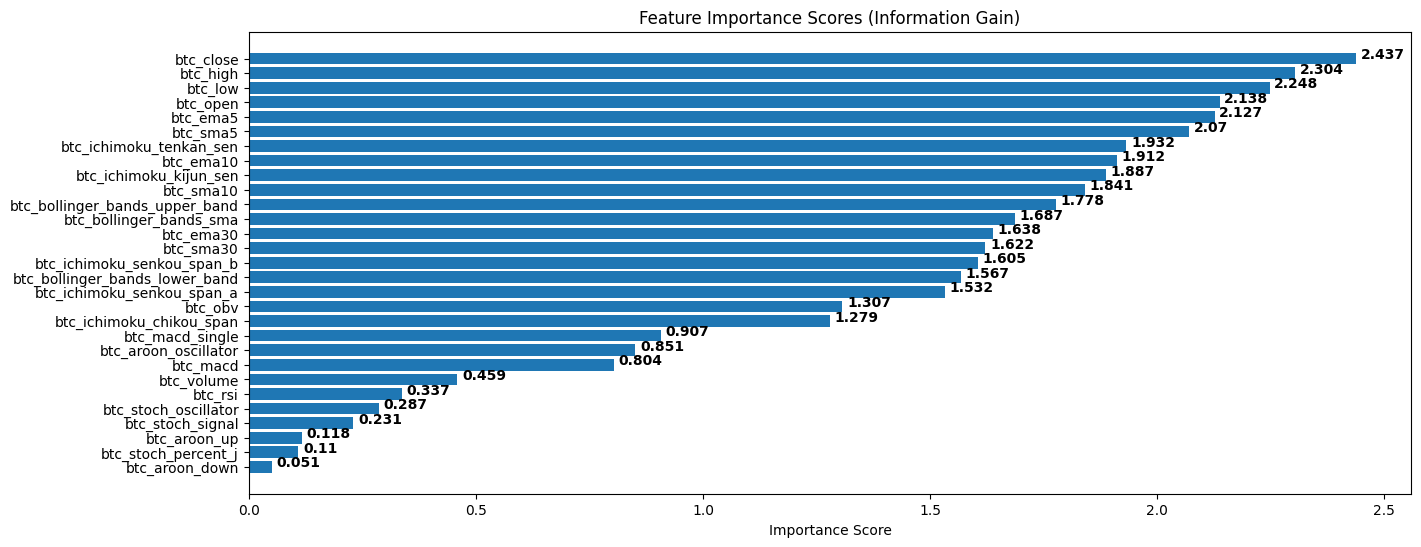

In [49]:
#########################
# Information Gain
#########################

from sklearn.feature_selection import mutual_info_regression

# Apply Information Gain
ig = mutual_info_regression(X, y)

# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(X.columns)):
    feature_scores[X.columns[i]] = ig[i]

# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print('Feature:', feature, 'Score:', score)


# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots(figsize=(15,6))
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

# Add importance scores as labels on the horizontal bar chart
for i, v in enumerate([score for feature, score in sorted_features]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()

target                            1.000000
btc_close                         0.994965
btc_high                          0.992903
btc_low                           0.991970
btc_ema5                          0.991014
btc_open                          0.990294
btc_sma5                          0.989214
btc_ema10                         0.984480
btc_ichimoku_tenkan_sen           0.983087
btc_sma10                         0.980352
btc_bollinger_bands_sma           0.962150
btc_ichimoku_kijun_sen            0.959596
btc_bollinger_bands_upper_band    0.956990
btc_ema30                         0.955113
btc_sma30                         0.944420
btc_bollinger_bands_lower_band    0.933896
btc_ichimoku_chikou_span          0.868907
btc_ichimoku_senkou_span_a        0.828607
btc_ichimoku_senkou_span_b        0.742921
btc_obv                           0.529946
btc_volume                        0.287028
btc_macd_single                   0.277586
btc_macd                          0.253534
btc_stoch_o

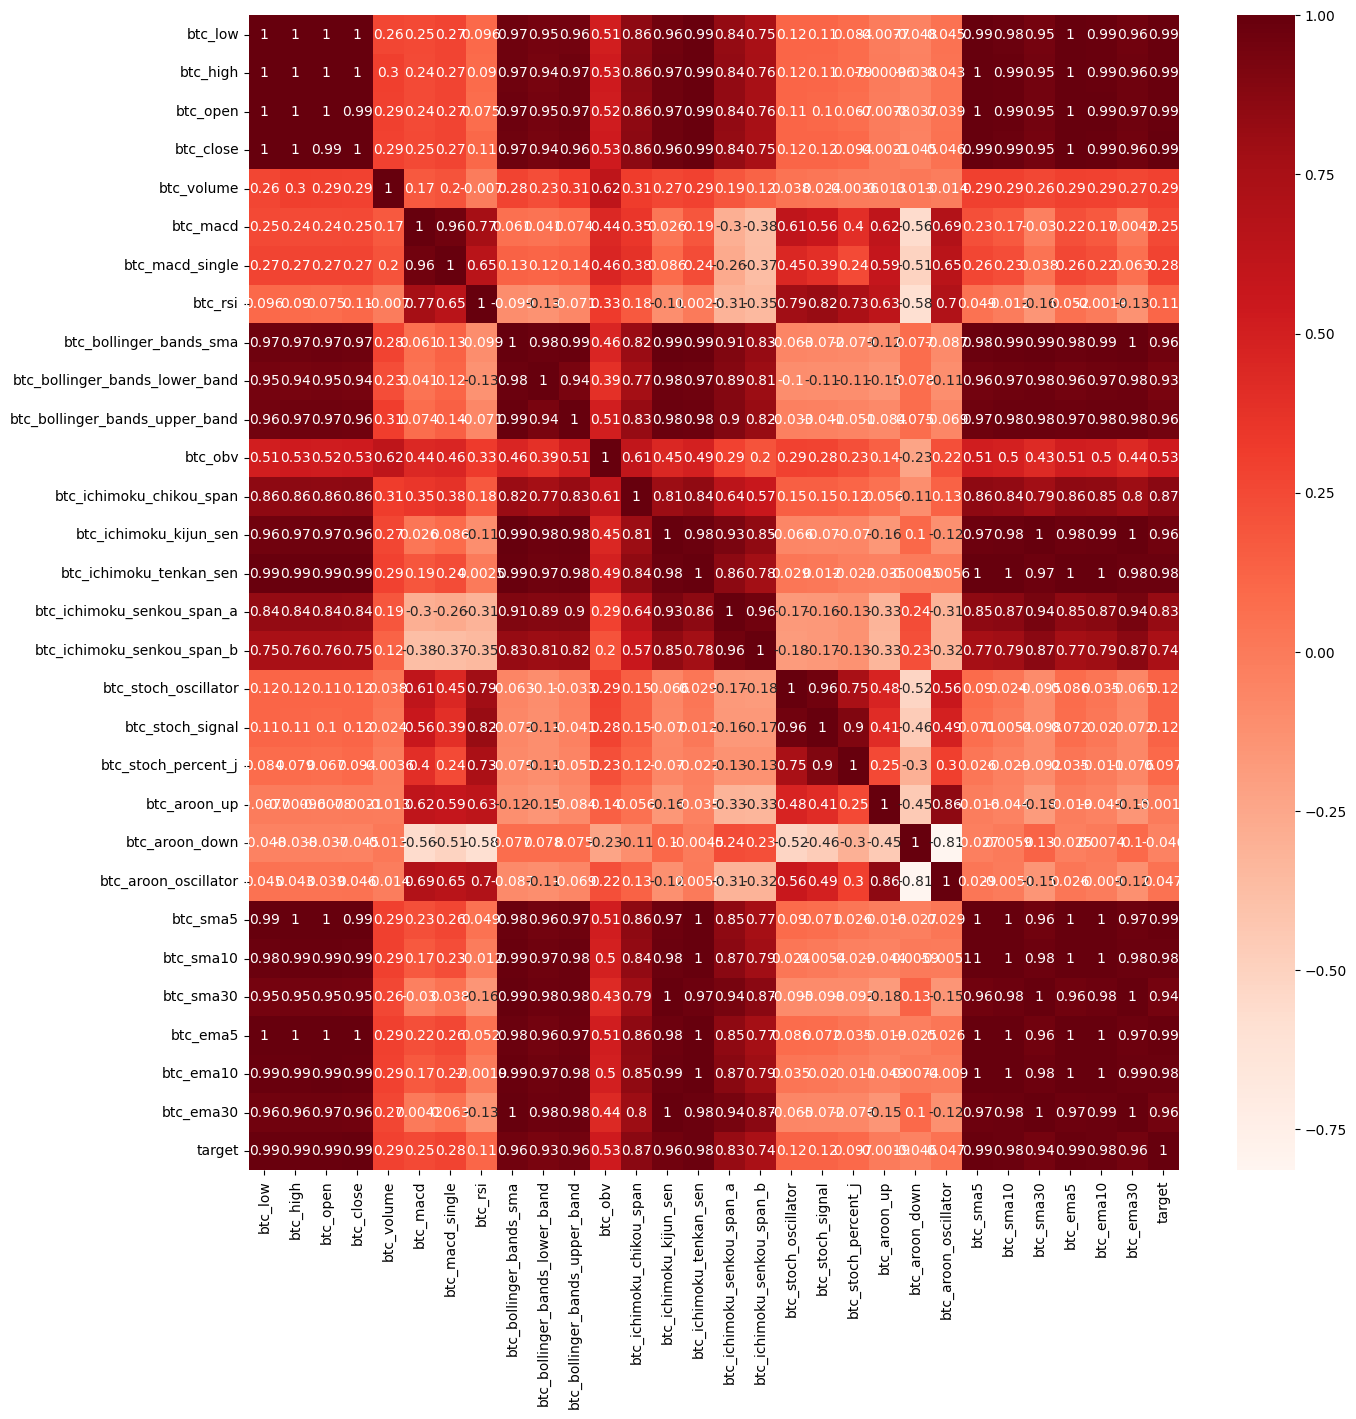

In [66]:
#########################
# Pearson correlation
#########################
import seaborn as sns
df = btc_df_with_target.drop(['btc_dt'], axis=1)
fig, ax = plt.subplots(figsize=(15,15))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

#Correlation with output variable
cor_target = abs(cor["target"])
#Selecting highly correlated features
relevant_features = cor_target.sort_values(ascending=False)
relevant_features

In [101]:
#########################
# Recursive Feature Elimination
#########################
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from operator import itemgetter

# Create X, y dataset
X = btc_df_with_target.drop(['btc_dt','target'], axis=1)
y = btc_df_with_target['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

regressor = RandomForestRegressor(n_estimators=1000, max_depth=20)

# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

features = X_train.columns.to_list()
for rank, feat in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(rank, feat)

1 btc_low
1 btc_high
1 btc_open
1 btc_close
1 btc_macd_single
1 btc_bollinger_bands_upper_band
1 btc_obv
1 btc_ichimoku_chikou_span
1 btc_stoch_oscillator
1 btc_ema5
2 btc_rsi
3 btc_volume
4 btc_sma5
5 btc_ichimoku_senkou_span_a
6 btc_aroon_oscillator
7 btc_stoch_percent_j
8 btc_macd
9 btc_aroon_up
10 btc_stoch_signal
11 btc_ichimoku_senkou_span_b
12 btc_ichimoku_tenkan_sen
13 btc_bollinger_bands_lower_band
14 btc_aroon_down
15 btc_sma10
16 btc_sma30
17 btc_ema10
18 btc_ema30
19 btc_bollinger_bands_sma
20 btc_ichimoku_kijun_sen


# Unsupervised Feature Selection Techniques

1. Principal Component Analysis (PCA)
2. Independent Component Analysis (ICA)
3. Non-Negative Matrix Factorization (NMF)
4. t-distributed Stochastic Neighbor Embedding (t-SNE)
5. Autoencoder

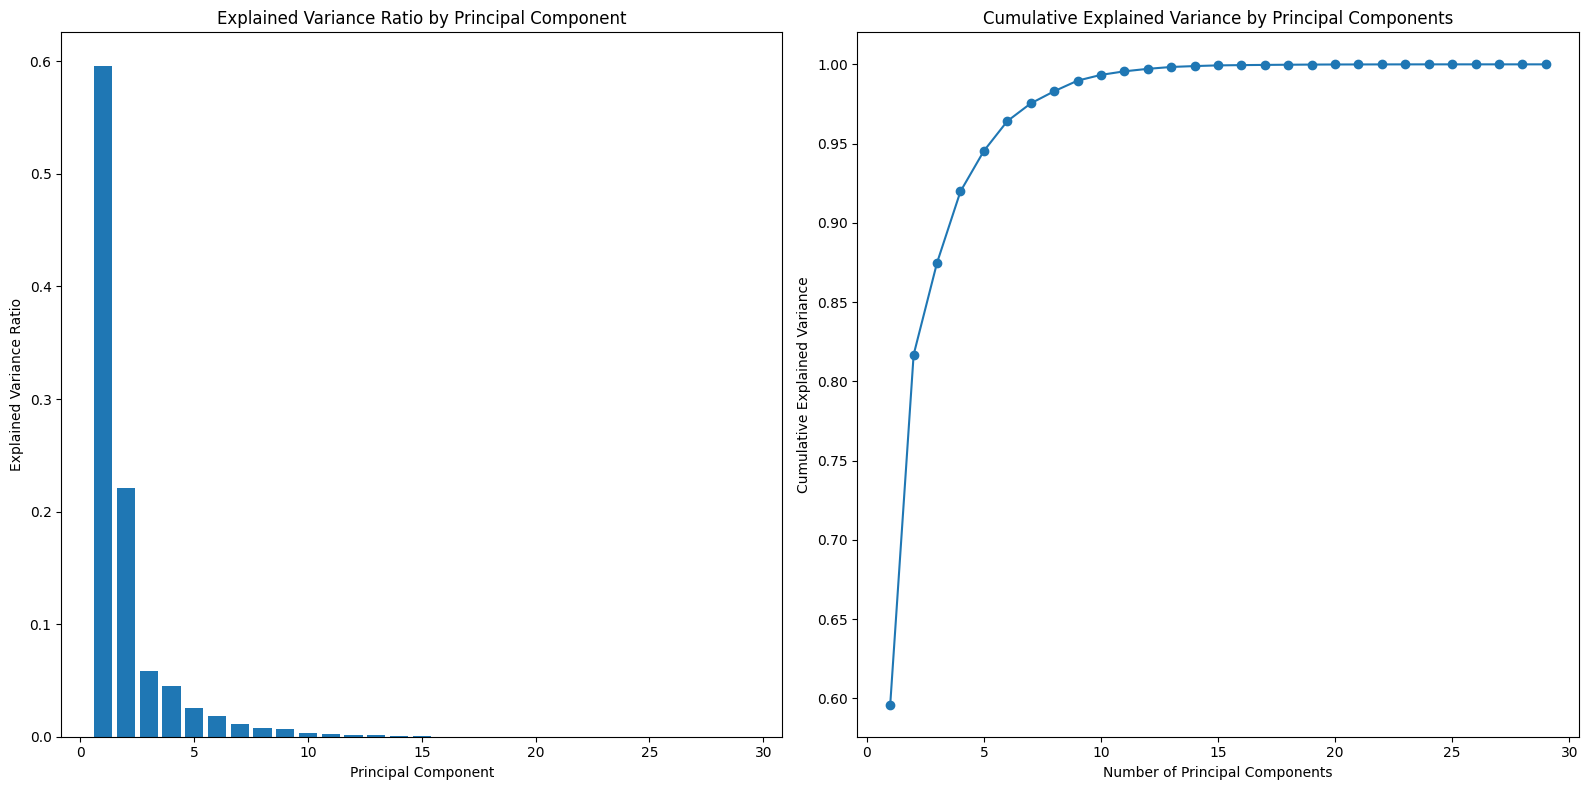

,0,1
0,PC0,btc_ema10
1,PC1,btc_rsi
2,PC2,btc_stoch_percent_j
3,PC3,btc_volume
4,PC4,btc_aroon_down
5,PC5,btc_aroon_up
6,PC6,btc_obv
7,PC7,btc_stoch_oscillator
8,PC8,btc_ichimoku_chikou_span
9,PC9,btc_rsi


In [122]:
#########################
# Principal Component Analysis (PCA)
#########################
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create X, y dataset
X = btc_df_with_target.drop(['btc_dt','target'], axis=1)
y = btc_df_with_target['target']
feature_names = X.columns

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()


# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

df

In [124]:
#########################
# Independent Component Analysis (ICA)
#########################
from sklearn.decomposition import FastICA
# Create X, y dataset
X = btc_df_with_target.drop(['btc_dt','target'], axis=1)
y = btc_df_with_target['target']
transformer = FastICA(n_components=7,random_state=0,whiten='unit-variance')
X_transformed = transformer.fit_transform(X)

#Creating the dataframe
print('####### Final Independent Components ######')
ReducedData=pd.DataFrame(data=X_transformed, columns=[f'IC{i}' for i in range(1,8)])
print(ReducedData.head(10))

(1077, 7)

In [133]:
#########################
# t-distributed Stochastic Neighbor Embedding (t-SNE)
#########################
from sklearn.manifold import TSNE

X = btc_df_with_target.drop(['btc_dt','target'], axis=1)
y = btc_df_with_target['target']
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

d1=X_tsne[:, 0]
d2=X_tsne[:, 1]

0.23768939077854156


array([ 39.90508 ,  39.643562,  40.264095, ..., -21.915852, -30.250158,
       -22.121563], dtype=float32)